# Quantum Teleportation Algorithm (Protocol)

The quantum teleportation protocol is a foundational quantum communication method that transfers an arbitrary qubit state from one location (Alice) to another (Bob) using entanglement and classical communication.

The circuit begins by creating a Bell pair shared between Alice and Bob.
Alice entangles her unknown qubit with her half of the Bell pair and performs mid-circuit measurements on her qubits.
The resulting classical bits are sent to Bob, who applies conditional quantum gates to reconstruct the original state on his qubit, completing the teleportation process.

This example highlights the use of mid-circuit measurements in QMod, which are essential for simulating hybrid quantum–classical behavior in quantum algorithms.

## Algorithm Description

The protocol starts with an arbitrary quantum state on **`alice_qubit`**, which we aim to teleport to Bob.
##### 1. Bell State Creation
- Apply a **Hadamard (`H`)** gate to **`bell_pair_qubit`**.  
- Apply a **CNOT** gate with **`bell_pair_qubit`** as control and **`bob_qubit`** as target.  
These two qubits now form a bell state.
##### 2. Entangling Alice’s Qubit with the Bell Pair
- Apply a **CNOT** gate from **`alice_qubit`** to **`bell_pair_qubit`**.  
- Apply a **Hadamard (`H`)** gate on **`alice_qubit`**.  
This step entangles Alice’s qubit with the Bell pair.
##### 3. Mid-Circuit Measurement
Measure **`alice_qubit`** and **`bell_pair_qubit`**.  
The measurement results will be later used for conditional corrections.
##### 4. Classically Controlled Corrections
Depending on the measurement outcomes:  
- If **`bell_pair_qubit`** measures `1`, apply **`X`** on **`bob_qubit`**.  
- If **`alice_qubit`** measures `1`, apply **`Z`** on **`bob_qubit`**.  

These classically controlled gates complete the teleportation process, reconstructing the original quantum state on **`bob_qubit`**.

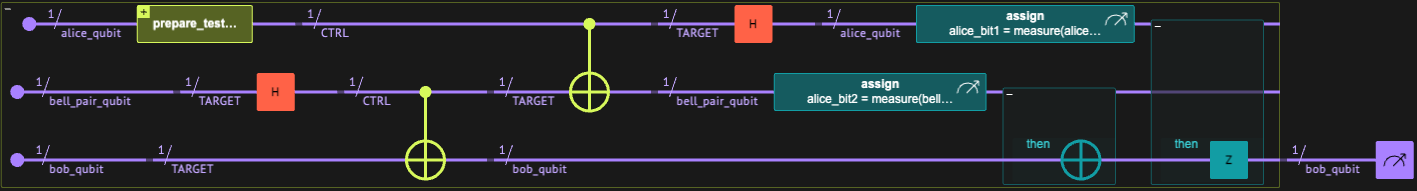
<center>
<figcaption align = "middle"> Figure 1. Quantum Teleportation algorithm </figcaption>
</center>

## Mid-Circuit Measurement

Mid-circuit measurement is a key feature in quantum computation that allows measuring a qubit **while the circuit is still running**, rather than only at the end of execution.  
This capability enables **classical feedback** — where measurement results influence subsequent quantum operations within the same program.

In QMod, mid-circuit measurement is implemented through the `measure()` function.  
Unlike a final measurement, which collapses the qubit state at the end of a circuit, `measure()` can be invoked **within** a quantum function to extract partial information and conditionally control later operations.

The `measure()` function returns a **symbolic value**, representing the outcome of the measurement (either `0` or `1`).  
This symbolic value is determined only during the actual quantum run of the program, but it can already be used to define **conditional logic** at circuit construction time.


## How to Build the Algorithm with Classiq

We define a qunatum function `quantum_teleportation` that takes three qubits:
one for Alice (`alice_qubit`), one for Bob (`bob_qubit`), and one for their shared Bell pair (`bell_pair_qubit`).

**Alice state preperation:** This function defines Alice’s input state for teleportation.
It can be replaced with any other state-preparation routine as needed. We chose a simple superposition.

In [2]:
import numpy as np

from classiq import *


@qfunc
def prepare_test_state(q: QBit) -> None:
    H(q)

### Classiq's implematation

In [3]:
@qfunc
def quantum_teleportation(
    alice_qubit: QBit, bob_qubit: QBit, bell_pair_qubit: QBit
) -> None:

    # Step 1: Create Bell pair between bell_pair_qubit and Bob's qubit
    H(bell_pair_qubit)
    CX(bell_pair_qubit, bob_qubit)

    # Step 2: Alice performs Bell measurement on her qubits
    CX(alice_qubit, bell_pair_qubit)
    H(alice_qubit)

    # Step 3: Measure Alice's qubits to get classical bits
    alice_bit1 = measure(alice_qubit)
    alice_bit2 = measure(bell_pair_qubit)

    # Step 4: Apply corrections to Bob's qubit based on Alice's measurements
    if_(alice_bit2, lambda: X(bob_qubit))  # Apply X if bell_pair_qubit measurement is 1
    if_(alice_bit1, lambda: Z(bob_qubit))  # Apply Z if alice_qubit measurement is 1

**Main function:** allocates the necessary qubits, prepares Alice’s qubit state,
and then calls the quantum teleportation function to perform the protocol.

In [4]:
@qfunc
def main(bob_qubit: Output[QBit]) -> None:

    alice_qubit = QBit()
    bell_pair_qubit = QBit()

    # Allocate qubits
    allocate(1, alice_qubit)
    allocate(1, bob_qubit)
    allocate(1, bell_pair_qubit)

    # Prepare the state to be teleported on Alice's qubit
    prepare_test_state(alice_qubit)

    # Perform teleportation
    quantum_teleportation(alice_qubit, bob_qubit, bell_pair_qubit)

**Create model and synthesize:** We create a quantum model using the defined main function, synthesize it into a circuit, and visualize it.

In [6]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34mqX9zmy59P4S6y0zByViJkvoS


**Execute** the synthesized quantum program to observe Bob’s qubit after teleportation.

In [7]:
job = execute(qprog)
job.get_sample_result().dataframe

bob_qubit  count  probability bitstring
0          1   1029     0.502441         1
1          0   1019     0.497559         0

## Technical Notes

Start with Alice’s qubit in the state:
$$
\lvert a \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle 
$$

Bob’s and the Bell-pair qubits start in the state:
$$\lvert b \rangle =  \lvert p \rangle=\lvert 0 \rangle$$

After creating a bell state between $\lvert p \rangle$ and $\lvert b \rangle$
$$
\lvert \psi \rangle_{pb} = \tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb})
$$
The total state is now:  
$$
\lvert \psi \rangle_{apb} = (\alpha \lvert 0 \rangle_{a} + \beta \lvert 1 \rangle_{a} )\otimes(\tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb}))=\tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 100 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 111 \rangle_{apb}
$$
After applying CX(a,p):  
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 110 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 101 \rangle_{apb}
$$

Applying H(a):
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{2}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 100 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 011 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 111 \rangle_{apb}+\tfrac{\beta}{2}\lvert 010 \rangle_{apb}-\tfrac{\beta}{2}\lvert 110 \rangle_{apb}+\tfrac{\beta}{2}\lvert 001 \rangle_{apb}-\tfrac{\beta}{2}\lvert 101 \rangle_{apb}
$$
Simplify:
$$
\begin{split}
\lvert \psi \rangle_{apb} = \tfrac{1}{2} \big[ 
&\lvert 00 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} + \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 01 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} + \beta \lvert 0 \rangle_{b}) \\
&+ \lvert 10 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} - \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 11 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} - \beta \lvert 0 \rangle_{b}) 
\big]
\end{split}
$$
The classical correction operations based on Alice’s and the Bell-pair measurement results are:
$$
\begin{array}{ccl}
00 &\rightarrow& I(b) \\
01 &\rightarrow& X(b) \\
10 &\rightarrow& Z(b) \\
11 &\rightarrow& Z(b)X(b)
\end{array}
$$

This function is creating a QMod-native version of this code:

In [ ]:
write_qmod(main, "quantum_teleportation")

## References

<a id='QTWiki'>[1]</a>: [Qunatum Teleportation (Wikipedia)](https://en.wikipedia.org/wiki/Quantum_teleportation)
